# Deep Q-Learning for Stock Trading using Transformers

In [1]:
!pip install yfinance

In [2]:
#Importing all libraries needed for the project.

import numpy as np 
import pandas as pd
import yfinance as yf
import torch
import matplotlib.pyplot as plt
import random
import time
import copy
import collections
import pickle
from IPython import embed

## Data Preprocessing

In [3]:
def download_dataset(stocks=['AAPL', 'MSFT'], start='1990-01-01', end='2023-01-01'):
    """This function downloads the stock data for 2 stocks from yahoo finance in a certain time window.
    
    Arguments
    ---------
    stocks : list
        The tickers of the stocks that will be traded.
    start : string
        The start date of the dataset. Has to be the format YYYY-MM-DD (example:2000-01-01)
    end: string
        The end date of the dataset. Has to be the format YYYY-MM-DD (example:2023-01-01)
    
    Returns
    ---------
    full_dataset : pandas.core.frame.DataFrame
        Dataframe containing stocks, vix and nasdaq price and volume information.
    
    """
    
    
    #Downloading stock data to be used
    stock1_df=yf.download(stocks[0], start=start, end=end, progress=True)
    stock2_df=yf.download(stocks[1], start=start, end=end, progress=True)
    
    #Downloading VIX index data to be used. VIX is a volatility index for the market.
    vix_df=yf.download('^VIX', start=start, end=end, progress=True)
    
    #Downloading NASDAQ index data to be used. NASDAQ is a stock exchange mainly for tech stocks.
    nsdq_df=yf.download('^IXIC', start=start, end=end, progress=True)
    
    #Renaming the Columns
    stock1_df.rename(columns={'Open': f'{stocks[0]} Open', 'High': f'{stocks[0]} High', 'Low': f'{stocks[0]} Low', 'Close': f'{stocks[0]} Close', 'Adj Close': f'{stocks[0]} Adj Close', 'Volume': f'{stocks[0]} Volume'}, inplace=True)
    stock2_df.rename(columns={'Open': f'{stocks[1]} Open', 'High': f'{stocks[1]} High', 'Low': f'{stocks[1]} Low', 'Close': f'{stocks[1]} Close', 'Adj Close': f'{stocks[1]} Adj Close', 'Volume': f'{stocks[1]} Volume'}, inplace=True)
    vix_df.rename(columns={'Open': 'Vix Open', 'High': 'Vix High', 'Low': 'Vix Low', 'Close': 'Vix Close', 'Adj Close': 'Vix Adj Close', 'Volume': 'Vix Volume'}, inplace=True)
    nsdq_df.rename(columns={'Open': 'Nasdaq Open', 'High': 'Nasdaq High', 'Low': 'Nasdaq Low', 'Close': 'Nasdaq Close', 'Nasdaq Close': 'Nasdaq Adj Close', 'Volume': 'Nasdaq Volume'}, inplace=True)
    
    #Concatenating all dataset into one set.
    full_dataset=pd.concat([stock1_df, stock2_df, vix_df, nsdq_df], axis=1)
    
    #Dropping the volume column for the VIX index because the VIX does not have volume.
    full_dataset.drop(['Vix Volume'], axis=1, inplace=True)
    
    return full_dataset

In [4]:
# Converting the pandas dataset to numpy arrays
stocks=['AAPL', 'MSFT']
observations = download_dataset(stocks)
prices = observations[[f'{stocks[0]} Adj Close', f'{stocks[1]} Adj Close']]
observations = observations.to_numpy()
prices = prices.to_numpy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Size of the sequences to be fed into the transformer
window_shape = 64

In [6]:
# Splitting the dataset into training, validation and testing datasets

split = 0.7

dataset_size = observations.shape[0]

train_cutoff = int(dataset_size * split)
val_cutoff = train_cutoff + int((dataset_size-train_cutoff)*(1-split))

train_obs = observations[:train_cutoff,:]
train_prices = prices[:train_cutoff,:]
val_obs = observations[train_cutoff-window_shape:val_cutoff,:]
val_prices = prices[train_cutoff-1:val_cutoff,:]
test_obs = observations[val_cutoff-window_shape:,:]
test_prices = prices[val_cutoff-1:,:]
val_test_obs = observations[train_cutoff-window_shape:,:]
val_test_prices = prices[train_cutoff-1:,:]

In [7]:
# Normalizing the data between 0.1 and 1.1

train_obs_norm = (train_obs - np.min(train_obs, axis=0))/(np.max(train_obs, axis=0) - np.min(train_obs, axis=0))+0.1
train_prices_norm = (train_prices - np.min(train_prices, axis=0))/(np.max(train_prices, axis=0) - np.min(train_prices, axis=0))+0.1

val_obs_norm = (val_obs - np.min(val_obs, axis=0))/(np.max(val_obs, axis=0) - np.min(val_obs, axis=0))+0.1
val_prices_norm = (val_prices - np.min(val_prices, axis=0))/(np.max(val_prices, axis=0) - np.min(val_prices, axis=0))+0.1

test_obs_norm = (test_obs - np.min(test_obs, axis=0))/(np.max(test_obs, axis=0) - np.min(test_obs, axis=0))+0.1
test_prices_norm = (test_prices - np.min(test_prices, axis=0))/(np.max(test_prices, axis=0) - np.min(test_prices, axis=0))+0.1

val_test_obs_norm = (val_test_obs - np.min(val_test_obs, axis=0))/(np.max(val_test_obs, axis=0) - np.min(val_test_obs, axis=0))+0.1
val_test_prices_norm = (val_test_prices - np.min(val_test_prices, axis=0))/(np.max(val_test_prices, axis=0) - np.min(val_test_prices, axis=0))+0.1

In [8]:
from numpy.lib.stride_tricks import sliding_window_view

#Create sequences (unnorm dataset are used to get the actual dollar gains or losses)
train_seq = sliding_window_view(train_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
train_prices_seq = train_prices_norm[window_shape-1:,:]
train_prices_unnorm = train_prices[window_shape-1:,:]
val_seq = sliding_window_view(val_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
val_prices_seq = val_prices_norm
val_prices_unnorm = val_prices
test_seq = sliding_window_view(test_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
test_prices_seq = test_prices_norm
test_prices_unnorm = test_prices
val_test_seq = sliding_window_view(val_test_obs_norm, window_shape = window_shape, axis=0).swapaxes(1,2)
val_test_prices_seq = val_test_prices_norm
val_test_prices_unnorm = val_test_prices

In [9]:
# Create tensors from the numpy arrays

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_seq_tensor = torch.from_numpy(train_seq).float()
train_prices_seq_tensor = torch.from_numpy(train_prices_seq).float()
train_prices_unnorm_tensor = torch.from_numpy(train_prices_unnorm).float()
val_seq_tensor = torch.from_numpy(val_seq).float()
val_prices_seq_tensor = torch.from_numpy(val_prices_seq).float()
val_prices_unnorm_tensor = torch.from_numpy(val_prices_unnorm).float()
test_seq_tensor = torch.from_numpy(test_seq).float()
test_prices_seq_tensor = torch.from_numpy(test_prices_seq).float()
test_prices_unnorm_tensor = torch.from_numpy(test_prices_unnorm).float()
val_test_seq_tensor = torch.from_numpy(val_test_seq).float()
val_test_prices_seq_tensor = torch.from_numpy(val_test_prices_seq).float()
val_test_prices_unnorm_tensor = torch.from_numpy(val_test_prices_unnorm).float()

/tmp/ipykernel_3080862/3803502347.py:3: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1680557665316/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  train_seq_tensor = torch.from_numpy(train_seq).float()


## Environment Creation

In [14]:
class Trading_Env():
    """This class simulates a trending environment of 2 stocks.
    
    Arguments
    ---------
    observations : Tensor
        The normalized tensors containing the observations of both stocks.
    prices : Tensor
        The normalized tensors containing the closing prices of both stocks.
    unnorm_prices: Tensor
        The unnormalized tensors containing the closing prices of both stocks.
    commission: float
        The commission percentage per trade.
    """
    # This method initializes all necessary variables of the environment
    def __init__(self, observations, prices, unnorm_prices, commission=0):
        self.iter = 0
        self.prev_prices = torch.zeros(prices.shape[1])
        self.unnorm_prev_prices = torch.zeros(unnorm_prices.shape[1])
        self.holdings = torch.zeros(prices.shape[1])
        self.holding_index = None
        self.terminated = torch.tensor([0])
        self.observations = observations
        self.prices = prices
        self.unnorm_prices = unnorm_prices
        self.all_actions = torch.from_numpy(np.array([[0, 0], [0, 1], [0, -1],
                                                      [1, 0], [1, 1], [1, -1],
                                                      [-1, 0], [-1, 1], [-1, -1]]))
        self.commission = torch.tensor([commission, commission])
    
    # This method resets the environment and all associated variables.
    def reset(self):
        self.iter = 0
        self.prev_prices = self.prices[self.iter]
        self.unnorm_prev_prices = self.unnorm_prices[self.iter]
        self.holdings = torch.zeros(prices.shape[1])
        self.holding_index = torch.tensor([0])
        self.terminated = torch.tensor([0])
        
        return torch.cat((self.observations[self.iter], self.holdings.unsqueeze(0).repeat(self.observations[self.iter].shape[0], 1)), dim=1)
    
    # This method takes a step in the environment given a certain action and returns the next_state, the reward, the actual dollar gain, the index of the next possible holding, and whether the environment has terminated.
    def step(self, action):
        action = self.all_actions[action]
        reward = torch.sum(torch.where((torch.absolute(self.holdings)==torch.absolute(action)) & (self.holdings!=0), -(action*self.prices[self.iter])-self.prev_prices*self.holdings, 0), dim=-1, keepdim=True)
        reward = reward - torch.sum(torch.absolute(action)*self.prices[self.iter]*self.commission, dim=-1, keepdim=True)
        gain = torch.sum(torch.where((torch.absolute(self.holdings)==torch.absolute(action)) & (self.holdings!=0), -(action*self.unnorm_prices[self.iter])-self.unnorm_prev_prices*self.holdings, 0), dim=-1, keepdim=True)
        gain = gain - torch.sum(torch.absolute(action)*self.unnorm_prices[self.iter]*self.commission, dim=-1, keepdim=True)
        self.holdings = self.holdings + action
        self.holding_index = torch.nonzero(torch.all(torch.eq(self.holdings, self.all_actions), dim=1))[0][0]
        self.prev_prices = torch.absolute(action)*self.prices[self.iter]+(1-torch.absolute(action))*self.prev_prices
        self.unnorm_prev_prices = torch.absolute(action)*self.unnorm_prices[self.iter]+(1-torch.absolute(action))*self.unnorm_prev_prices
        self.iter += 1
        if self.iter == self.prices.shape[0]-1:
            self.terminated = torch.tensor([1])
        return torch.cat((self.observations[self.iter], (self.holdings*self.prev_prices).unsqueeze(0).repeat(self.observations[self.iter].shape[0], 1)), dim=1), reward, gain, self.holding_index, self.terminated

## Network Initialization

In [28]:
import torch.nn as nn 
import torch.nn.functional as F

# This class initializes a multi-headed transformer encoder in Pytorch.
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads=8, dropout=0.1):
        
        super().__init__()

        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, embed_dim)
        self.linear2 = nn.Linear(embed_dim, embed_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        x1 = x
        x = self.layer_norm1(x1)
        x, _ = self.attention(x, x, x)
        x = self.relu(x)
        x = self.dropout(x)
        x2 = x + x1
        x = self.layer_norm2(x2)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = x + x2

        return x

# This class initializes a transformer in pytorch with dueling q-learning
class Transformer(nn.Module):
    def __init__(self, features, embed_dim, seq_length,
                 num_heads=8, num_layers = 6, dropout=0.1):
        super(Transformer, self).__init__()
        self.positional_encoding = nn.Parameter(torch.rand(seq_length, embed_dim))
        self.linear1 = nn.Linear(features, embed_dim)

        self.layers = nn.ModuleList([TransformerEncoder(embed_dim, num_heads, dropout) for i in range(num_layers)])

        self.layer_norm = nn.LayerNorm(embed_dim)
        
        self.value = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 1)
        )

        self.advantage = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, 9)
        )
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x)
        x = x + self.positional_encoding
        x = self.dropout(x)
        for i, l in enumerate(self.layers):
            x = l(x)
            
        x = self.layer_norm(x)
        # Dueling DQN
        value = self.value(x)
        advantage = self.advantage(x)
        x = torch.add(value, (advantage - advantage.mean(dim=-1, keepdim=True)))
        if x.dim() == 3:
            x = x[:, -1, :]
        else:
            x = x[-1,:]
        return x

## DQN Agent Creation

In [29]:
import torch.nn.functional as F

# Class that creates the replay buffer used for the DQN algorithm
class ReplayBuffer:
    
    # initializes the replay buffer with a maximum size of buffer_size
    def __init__(self, buffer_size):
        self.buffer = collections.deque(maxlen=buffer_size)

    # Returns the current length of the buffer.
    def length(self):
        return len(self.buffer)

    # Adds a sample to the replay buffer.
    def append(self, sample):
        self.buffer.append(sample)

    # Returns a batch of samples from the replay buffer.
    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states = [self.buffer[idx][0] for idx in indices]
        actions = [self.buffer[idx][1] for idx in indices]
        rewards = [self.buffer[idx][2] for idx in indices]
        next_states = [self.buffer[idx][3] for idx in indices]
        gains = [self.buffer[idx][4] for idx in indices]
        hold_indices = [self.buffer[idx][5] for idx in indices]
        dones = [self.buffer[idx][6] for idx in indices]
        return torch.stack(states, dim=0).to(device), torch.stack(actions, dim=0).to(device), torch.stack(rewards, dim=0).to(device), torch.stack(next_states, dim=0).to(device), torch.stack(gains, dim=0).to(device), torch.stack(hold_indices, dim=0).to(device), torch.stack(dones, dim=0).to(device) 

# Class that Creates the DQN agent
class Double_Q_Learning_Agent():
    def __init__(self, train_seq, train_prices_seq, train_prices_unnorm, val_seq, val_prices_seq, 
                 val_prices_unnorm, test_seq, test_prices_seq, test_prices_unnorm,
                 val_test_seq, val_test_prices_seq, val_test_prices_unnorm, lr, batch_size, eps, buffer_size,
                 sync_steps, seed):
    
        self.lr = lr
        self.batch_size = batch_size
        self.gamma = 0.99
        self.eps = eps
        self.buffer_size = buffer_size
        self.sync_steps = sync_steps
        
        np.random.seed(seed)
        torch.manual_seed(seed)
        random.seed(seed)
        
        # All possible actions
        self.all_actions = torch.tensor([[0, 0], [0, 1], [0, -1],
                                         [1, 0], [1, 1], [1, -1],
                                         [-1, 0], [-1, 1], [-1, -1]]).to(device)
        
        # Legal action mask
        self.legal_actions = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                                       [0, -1e10, 0, 0, -1e10, 0, 0, -1e10, 0],
                                       [0, 0, -1e10, 0, 0, -1e10, 0, 0, -1e10],
                                       [0, 0, 0, -1e10, -1e10, -1e10, 0, 0, 0],
                                       [0, -1e10, 0, -1e10, -1e10, -1e10, 0, -1e10, 0],
                                       [0, 0, -1e10, -1e10, -1e10, -1e10, 0, 0, -1e10],
                                       [0, 0, 0, 0, 0, 0, -1e10, -1e10, -1e10],
                                       [0, -1e10, 0, 0, -1e10, 0, -1e10, -1e10, -1e10], 
                                       [0, 0, -1e10, 0, 0, -1e10, -1e10, -1e10, -1e10]]).to(device)
        
        # Environments
        self.train_env = Trading_Env(train_seq, train_prices_seq, train_prices_unnorm)
        self.val_env = Trading_Env(val_seq, val_prices_seq, val_prices_unnorm)
        self.test_env = Trading_Env(test_seq, test_prices_seq, test_prices_unnorm)
        self.val_test_env = Trading_Env(val_test_seq, val_test_prices_seq, val_test_prices_unnorm)
        
        # Networks used for value function approximation
        self.q_fun1 = Transformer(features=25, embed_dim=64, seq_length=window_shape,
                                  num_heads=4, num_layers = 2, dropout=0.2).to(device)
        self.q_fun2 = Transformer(features=25, embed_dim=64, seq_length=window_shape,
                                  num_heads=4, num_layers = 2, dropout=0.2).to(device)
        
        # Target Networks
        self.q_fun1_target = copy.deepcopy(self.q_fun1)
        self.q_fun2_target = copy.deepcopy(self.q_fun2)
        
        self.optimizer1 = torch.optim.Adam(self.q_fun1.parameters(), lr=self.lr)
        self.optimizer2 = torch.optim.Adam(self.q_fun2.parameters(), lr=self.lr)      
        
        self.replay_buffer = ReplayBuffer(self.buffer_size)
    
    # This method trains the network on the training set using double dqn, with replay buffers, dueling q-networks and target networks
    def train(self, episodes):
        sync_step = 1
        env = self.train_env
        ep_gains_list = []
        
        # Epochs loop
        for e in range(episodes):
            start = time.time()
            # reset the env
            obs = env.reset()
            done = False
            step = 1
            target = None
            ep_gains = 0
            # Training loop
            while not done:
#                 if step % 1000 == 0:
#                     print(f"Step: {step}/{env.observations.shape[0]}")
                # query the Q-function to get an action
                action = self.get_action(obs, env).cpu()
                # step the environment
                next_obs, reward, gain, holding_index, terminated = env.step(action)
                # append sample to replay buffer
                sample = (obs, action, reward, next_obs, gain, holding_index, terminated)
                self.replay_buffer.append(sample)
                # update q_value if the replay buffer has enough samples for a batch
                if self.replay_buffer.length() >= self.batch_size:
                    states_batch, actions_batch, rewards_batch, next_states_batch, gains_batch, holding_index_batch, dones_batch = self.replay_buffer.sample(self.batch_size)
                    loss, target = self.q_update(states_batch, actions_batch, rewards_batch, next_states_batch, holding_index_batch, dones_batch)
                    sync_step += 1
                # accumulate rewards
                ep_gains += gain
                # step obs
                obs = next_obs
                # end episode
                step += 1
                if terminated:
                    done = True
                    break
                
                # Reset target network to current Q-function
                if sync_step % self.sync_steps == 0:
                    self.q_fun1_target = copy.deepcopy(self.q_fun1)
                    self.q_fun2_target = copy.deepcopy(self.q_fun2)
            ep_gains_list.append(ep_gains.numpy())
            end = time.time()
            if e % 1 == 0:
                print(f"Episode={e+1}/{episodes},    Loss: {loss.item()},    Gain: {ep_gains}")
#                 print("Time Taken: ", end-start)
                print("Target:", target)
            
        return ep_gains_list
    
    # This method updates the q-functions
    def q_update(self, s, a, r, next_s, h, d):
            
            # Random choice of which of the two q-functions to update.
            choice = np.random.choice(2)

            if choice == 0:
                with torch.no_grad():
                    # compute TD target
                    legal_actions = self.legal_actions[h]
                    max_actions = torch.argmax(torch.add(self.q_fun1_target(next_s), legal_actions), dim=-1, keepdim=True)
                    target = torch.add(r, (1-d) * self.gamma * self.q_fun2_target(next_s).gather(1, max_actions))
                    
                # Compute TD error
                prediction = self.q_fun1(s).gather(1, a.unsqueeze(-1))
                
                self.optimizer1.zero_grad()
                
                # Compute loss and backpropagate
                loss = F.huber_loss(prediction, target)
                loss.backward()

                self.optimizer1.step()
                
                return loss, target

            else:
                with torch.no_grad():
                    # compute TD target
                    legal_actions = self.legal_actions[h]
                    max_actions = torch.argmax(torch.add(self.q_fun2_target(next_s), legal_actions), dim=-1, keepdim=True)
                    target = torch.add(r, (1-d) * self.gamma * self.q_fun1_target(next_s).gather(1, max_actions))
                    
                # Compute TD error
                prediction = self.q_fun2(s).gather(1, a.unsqueeze(-1))

                self.optimizer2.zero_grad()
                
                # Compute loss and backpropagate
                loss = F.huber_loss(prediction, target)
                loss.backward()

                self.optimizer2.step()
                return loss, target
    
    # This method runs on episode of in the environment without update the q-functions
    def run_one_episode(self, mode="train"):
        ep_gains = []
        # Choose the dataset to run the episode in
        if mode == "train":
            env = self.train_env
        elif mode == "val":
            env = self.val_env
        elif mode == "test":
            env = self.test_env
        else:
            env = self.val_test_env
        self.q_fun1.eval()
        self.q_fun2.eval()
        # reset the env
        obs = env.reset().to(device)
        done = False
        step = 1
        target = None
        start = time.time()
        #Training loop
        while not done:
#             if step % 100 == 0:
#                 print(f"Step: {step}/{env.observations.shape[0]}")
            # query the Q-function to get an action
            action = self.get_action(obs, env, train=False).cpu()
            # step the environment
            next_obs, reward, gain, holding_index, terminated = env.step(action)
            # accumulate rewards
            ep_gains.append(gain.numpy())
            # step obs
            obs = next_obs.to(device)
            # end episode
            step += 1
            if terminated:
                done = True
                break

        return ep_gains
    
    # function used to get the action based on the q-functions
    def get_action(self, obs, env, train = True):
        """Get action using epsilon-greedy strategy"""
        with torch.no_grad():
            if train and np.random.random() < self.eps:
                holding_index = env.holding_index
                legal_actions = np.argwhere(self.legal_actions[holding_index].cpu().numpy() == 0)
                action = np.random.choice(legal_actions[1])
                return torch.tensor([action])[0]
            else:
                obs = obs.to(device)
                holding_index = env.holding_index
                action_mask = self.legal_actions[holding_index]
                func1_values = torch.add(self.q_fun1(obs), action_mask)
                func2_values = torch.add(self.q_fun2(obs), action_mask)
                avg_values = torch.add(func1_values, func2_values)/2
                max_action_index = torch.argmax(avg_values)
                return max_action_index

## Training and Results

In [30]:
# Hyperparameter
episodes = 500
lr = 0.0001
seed = 0
eps = 0.1
sync_steps = 1000
batch_size = 128
buffer_size = 10000

# DQN agent
agent = Double_Q_Learning_Agent(train_seq_tensor, train_prices_seq_tensor, train_prices_unnorm_tensor, val_seq_tensor, 
                                val_prices_seq_tensor, val_prices_unnorm_tensor, test_seq_tensor, test_prices_seq_tensor, 
                                test_prices_unnorm_tensor, val_test_seq_tensor, val_test_prices_seq_tensor, 
                                val_test_prices_unnorm_tensor, lr, batch_size, eps, buffer_size, sync_steps, seed)

# Training
episode_gains = agent.train(episodes)

/home/a_eagu/anaconda3/envs/dqn/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Episode=1/500,    Loss: 0.0008354563033208251,    Gain: tensor([12.3890])
Target: tensor([[-0.1125],
        [-0.0637],
        [-0.0281],
        [-0.0695],
        [-0.1145],
        [-0.1431],
        [-0.1060],
        [-0.1053],
        [-0.0720],
        [-0.0680],
        [-0.0796],
        [-0.1518],
        [-0.0761],
        [-0.0714],
        [-0.0740],
        [-0.1173],
        [-0.0814],
        [-0.1174],
        [-0.1535],
        [-0.0880],
        [-0.0839],
        [-0.0559],
        [-0.1042],
        [-0.0781],
        [-0.0875],
        [-0.0719],
        [-0.0748],
        [-0.0718],
        [-0.0580],
        [-0.0931],
        [-0.0785],
        [-0.0605],
        [-0.0732],
        [-0.0908],
        [-0.0721],
        [-0.1281],
        [-0.0699],
        [-0.0506],
        [-0.0783],
        [-0.1072],
        [-0.0293],
        [-0.1099],
        [-0.0779],
        [-0.0826],
        [-0.0892],
        [-0.0541],
        [-0.0719],
        [-0.1169],
      

In [31]:
with open('agent.pickle', 'wb') as f:
    pickle.dump(agent, f)
with open('episode_gains.pickle', 'wb') as f:
    pickle.dump(episode_gains, f)

In [32]:
# with open('episode_gains.pickle', 'rb') as f:
#     episode_gains = pickle.load(f)
# with open('agent.pickle', 'rb') as f:
#     agent = pickle.load(f)

### Training Results

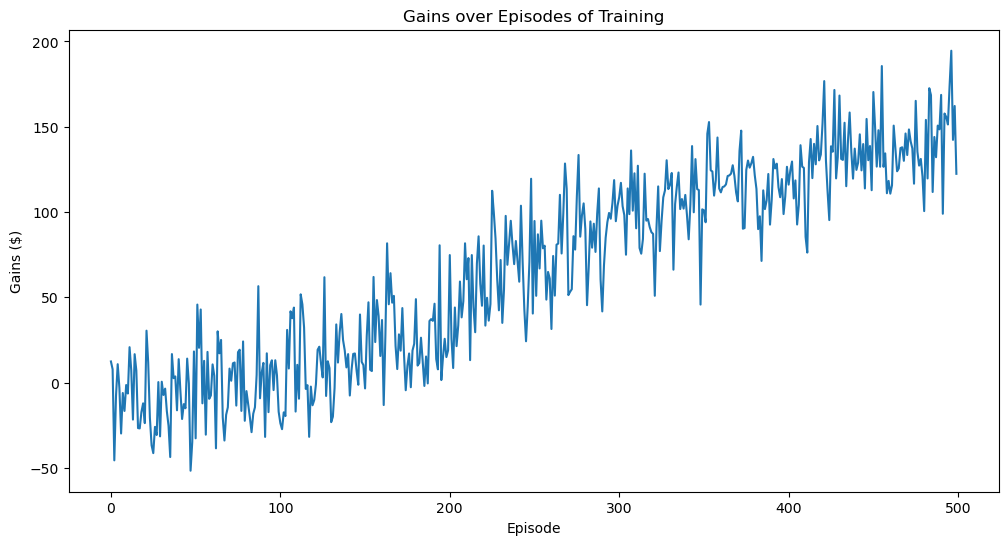

In [33]:
plt.figure(figsize=(12,6))
plt.plot(episode_gains)
plt.title("Gains over Episodes of Training")
plt.xlabel("Episode")
plt.ylabel("Gains ($)")
plt.show()

In [34]:
train_gains = agent.run_one_episode(mode="train")

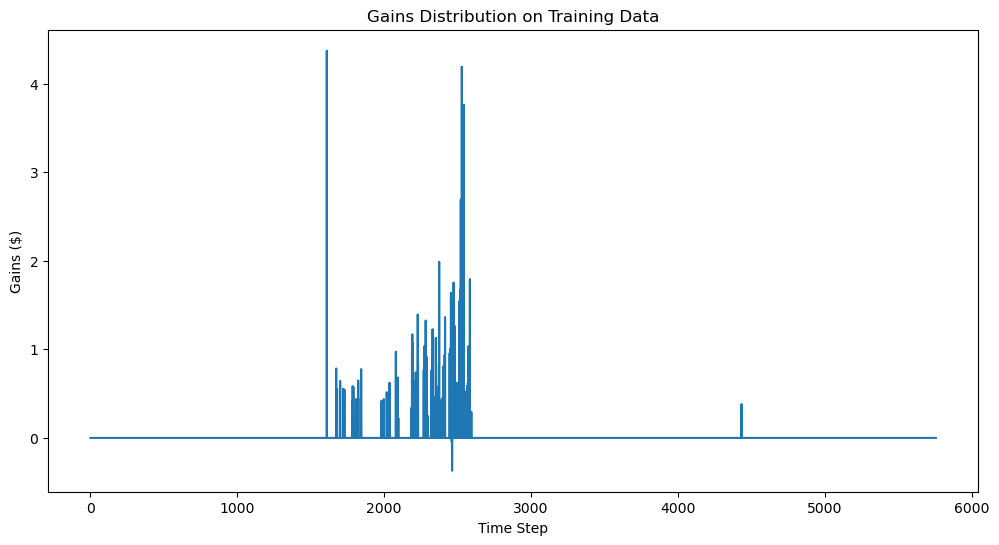

In [35]:
plt.figure(figsize=(12,6))
plt.plot(train_gains)
plt.title("Gains Distribution on Training Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

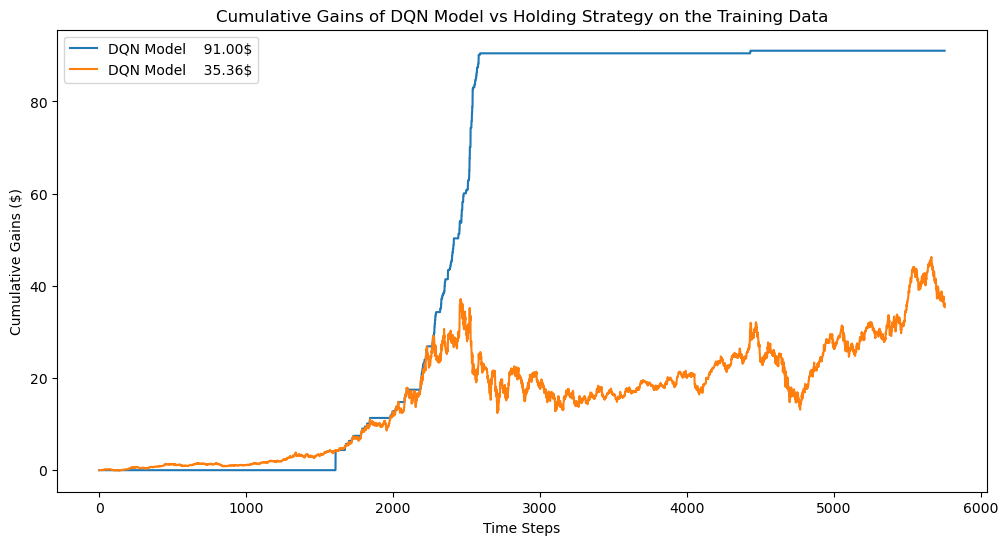

In [36]:
train_cumulative_gains = np.cumsum(train_gains)
plt.figure(figsize=(12,6))
plt.plot(train_cumulative_gains, label="DQN Model    {0:.2f}$".format(train_cumulative_gains[-1]))
train_holding_gains = np.sum(train_prices_unnorm-train_prices_unnorm[0], axis=1)
plt.plot(train_holding_gains, label="DQN Model    {0:.2f}$".format(train_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Training Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()

### Validation Results

In [37]:
val_gains = agent.run_one_episode(mode="val")

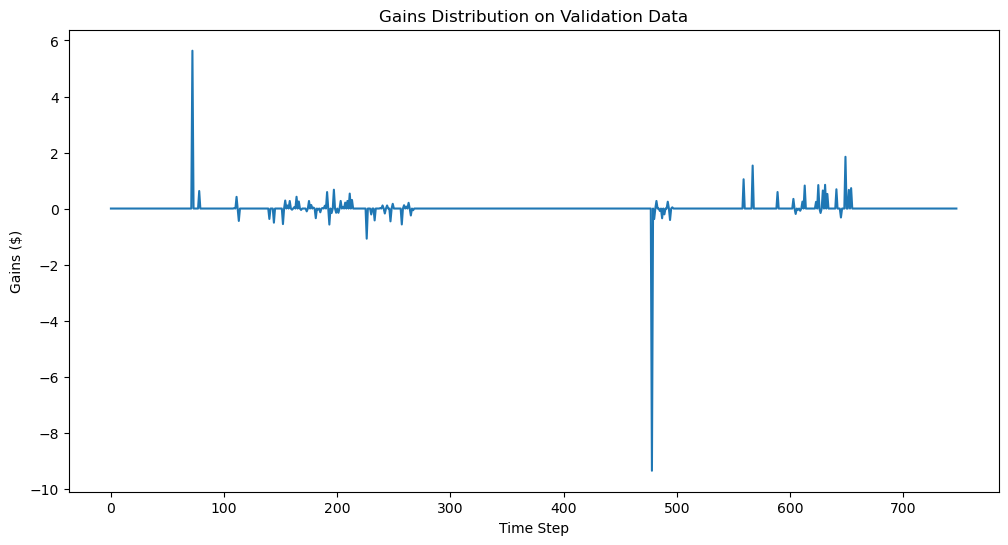

In [38]:
plt.figure(figsize=(12,6))
plt.plot(val_gains)
plt.title("Gains Distribution on Validation Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

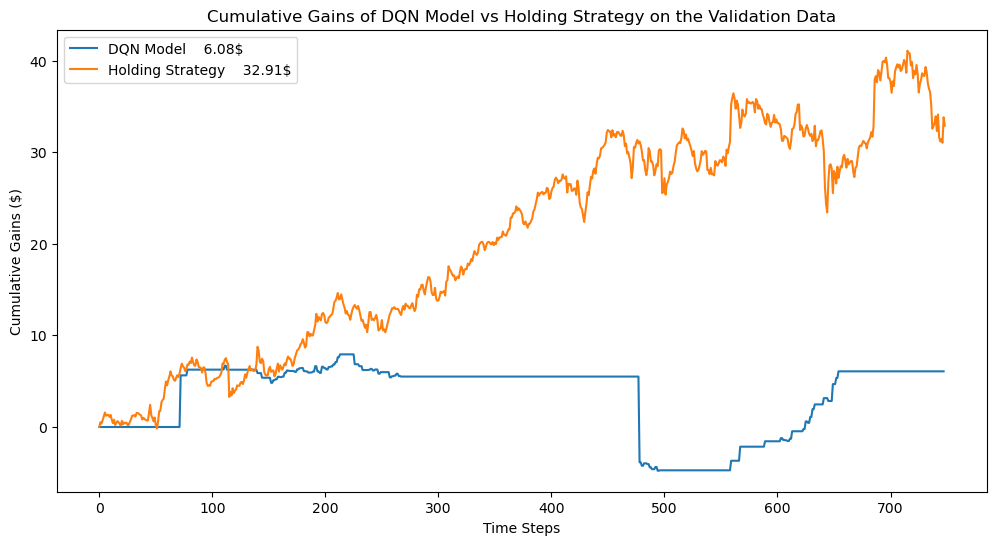

In [39]:
val_cumulative_gains = np.cumsum(val_gains)
plt.figure(figsize=(12,6))
plt.plot(val_cumulative_gains, label="DQN Model    {0:.2f}$".format(val_cumulative_gains[-1]))
val_holding_gains = np.sum(val_prices_unnorm-val_prices_unnorm[0], axis=1)
plt.plot(val_holding_gains, label="Holding Strategy    {0:.2f}$".format(val_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Validation Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()

### Testing Results

In [40]:
test_gains = agent.run_one_episode(mode="test")

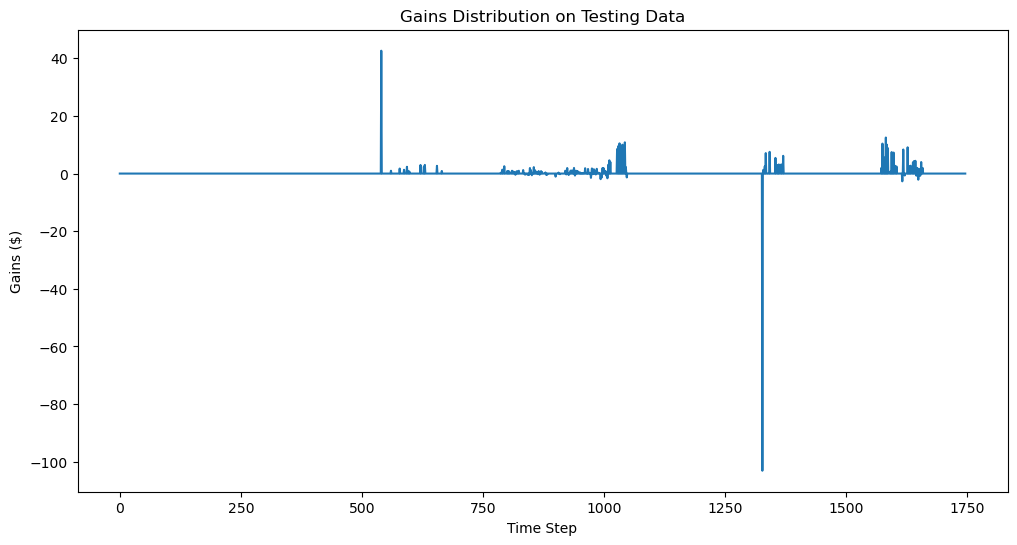

In [41]:
plt.figure(figsize=(12,6))
plt.plot(test_gains)
plt.title("Gains Distribution on Testing Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

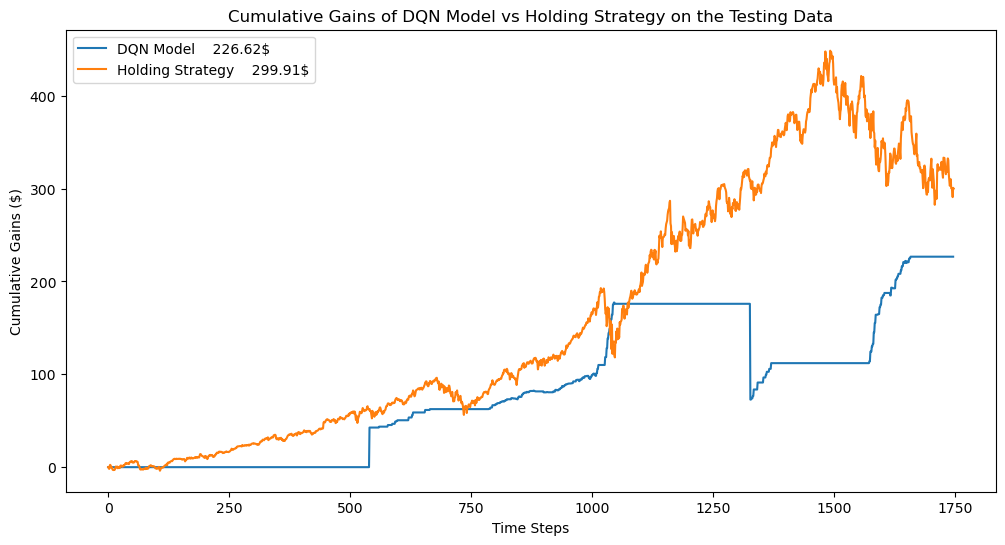

In [42]:
test_cumulative_gains = np.cumsum(test_gains)
plt.figure(figsize=(12,6))
plt.plot(test_cumulative_gains, label="DQN Model    {0:.2f}$".format(test_cumulative_gains[-1]))
test_holding_gains = np.sum(test_prices_unnorm-test_prices_unnorm[0], axis=1)
plt.plot(test_holding_gains, label="Holding Strategy    {0:.2f}$".format(test_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Testing Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()

### Validation and Testing Results

In [43]:
val_test_gains = agent.run_one_episode(mode="val_test")

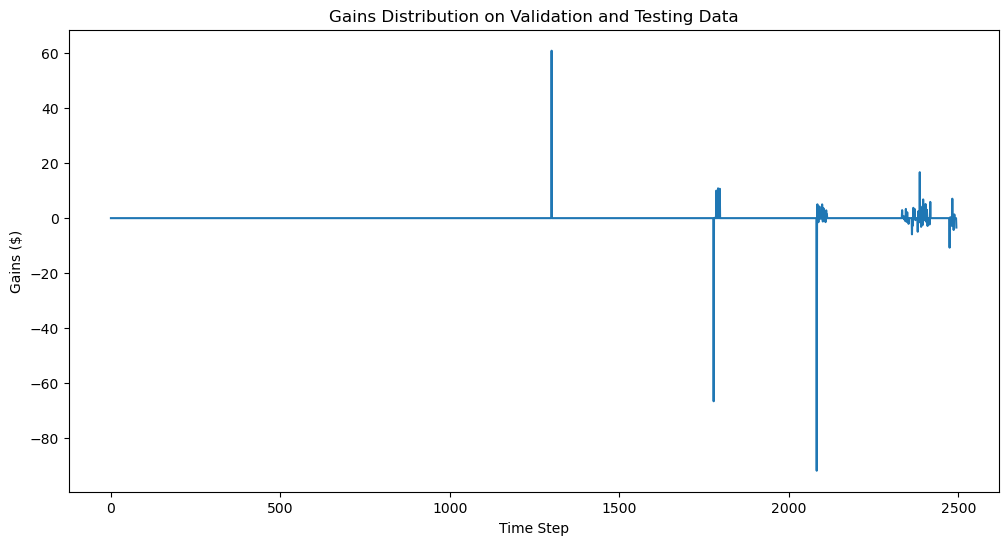

In [44]:
plt.figure(figsize=(12,6))
plt.plot(val_test_gains)
plt.title("Gains Distribution on Validation and Testing Data")
plt.xlabel("Time Step")
plt.ylabel("Gains ($)")
plt.show()

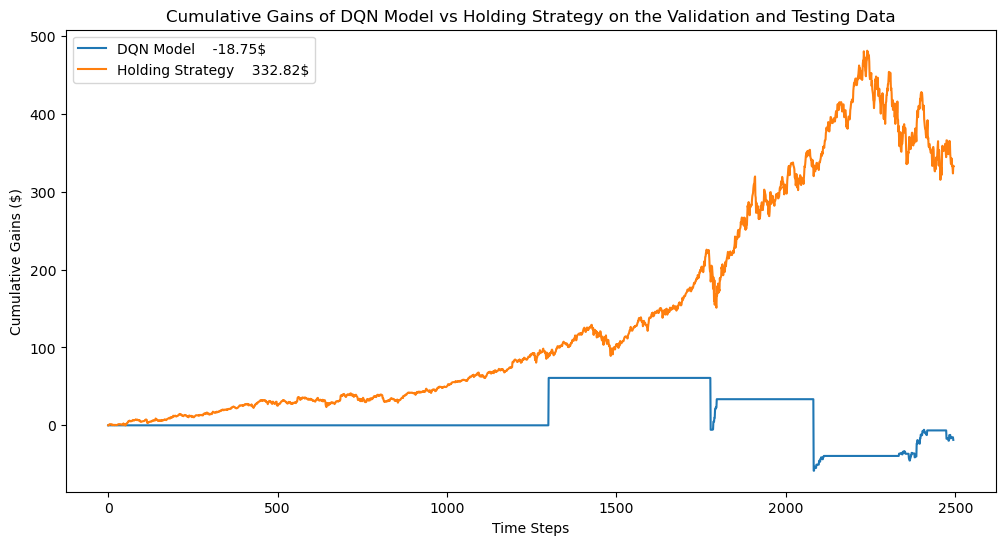

In [45]:
val_test_cumulative_gains = np.cumsum(val_test_gains)
plt.figure(figsize=(12,6))
plt.plot(val_test_cumulative_gains, label="DQN Model    {0:.2f}$".format(val_test_cumulative_gains[-1]))
val_test_holding_gains = np.sum(val_test_prices_unnorm-val_test_prices_unnorm[0], axis=1)
plt.plot(val_test_holding_gains, label="Holding Strategy    {0:.2f}$".format(val_test_holding_gains[-1]))
plt.title("Cumulative Gains of DQN Model vs Holding Strategy on the Validation and Testing Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Gains ($)")
plt.legend()
plt.show()